# CSHT along depth

Part of the heat crossing the 1km isobath, could be driven by the surface Ekman transport. This surface transport likely does not reach ice shelves, therefore it can be excluded

In [1]:
import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39265/status,
Dashboard: /proxy/39265/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38371,Workers: 7
Dashboard: /proxy/39265/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:40215,Total threads: 4
Dashboard: /proxy/45869/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:39247,


## 1 - Importing all required vars

#### 1.1 Sections, dates and lats cutoffs

In [12]:
session = cc.database.create_session()
start_time="1958-01"
end_time="2018-12"
exp = '01deg_jra55v140_iaf_cycle3'

lat_range = slice(-90,-59)

isobath_depth = 1000


#### 1.2 CSHT and ASC speed

In [4]:
#CSHT
src_files="/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/Ant_cross_slope_heat_terms_offline_1000m_*"

gl =glob.glob(src_files)
gl=sorted(gl)
print("%i netcdf data files"%len(gl))
IAF_HT=xr.open_mfdataset(gl, concat_dim='time', combine='nested')
IAF_HT_mean=IAF_HT.groupby('time.month').mean('time').mean('month')

732 netcdf data files


In [7]:
#ASC_speed
src_speed='/g/data/v45/wf4500/ASC_project_files/ASC_speed/OM2_IAF/*'

gl =glob.glob(src_speed)
gl=sorted(gl)
print("%i netcdf data files"%len(gl))
IAF_ASC=xr.open_mfdataset(gl, concat_dim='time', combine='nested')

732 netcdf data files


In [9]:
#binned ASC speed
src_speed_bin='/g/data/v45/wf4500/ASC_project_files/Binned_ASC_speed/OM2_IAF/*'

gl =glob.glob(src_speed_bin)
gl=sorted(gl)
print("%i netcdf data files"%len(gl))
Bin_ASC=xr.open_mfdataset(gl, concat_dim='time', combine='nested')

732 netcdf data files


#### 1.3 MLD for cutoff depth analysis

In [18]:
#importing monthly MLD since this is just for simple analysis and not for calculations
mld = cc.querying.getvar(exp,'mld',session,frequency='1 monthly',start_time=start_time,end_time=end_time).sel(time=slice(start_time,end_time))


In [20]:
mld  = mld.groupby('time.month').mean('time')  # Climatology
mld_annualmean  = mld.mean('month')  # annual mean

#### 1.4 Area, Volume, and  vars for averaging

In [41]:
#Area
tarea = cc.querying.getvar(exp,'area_t',session,n=1)

#dzt
dzt = cc.querying.getvar(exp,'dzt',session,start_time=start_time,end_time=end_time).sel(time=slice(start_time,end_time))
dzt_clim  = dzt.groupby('time.month').mean('time')  # Climatology
dzt_annualmean  = dzt_clim.mean('month')  # annual mean

#volume will be
tvol=tarea*dzt
tvol_clim=tarea*dzt_clim
tvol_annualmean=tarea*dzt_annualmean

## 2  - Evaluating MLD and cutoff depths

First, lets define the coordinates (binned and unbinned)

In [52]:
lon_bin_midpoints = IAF_HT.lon_bin_midpoints
lat_bin_midpoints = IAF_HT.lat_bin_midpoints.isel(time=0)
lon_along_contour = IAF_HT.lon_along_contour.isel(time=0)
lat_along_contour = IAF_HT.lat_along_contour.isel(time=0)

In [65]:
#mld along the contour
mld_annualmean_contour = mld_annualmean.sel(xt_ocean=lon_bin_midpoints,yt_ocean=lat_bin_midpoints,method='nearest')
mld_contour = mld.sel(xt_ocean=lon_bin_midpoints,yt_ocean=lat_bin_midpoints,method='nearest') #climatology
mld_contour_min = mld.sel(xt_ocean=lon_bin_midpoints,yt_ocean=lat_bin_midpoints,method='nearest').min(dim='month')
mld_contour_max = mld.sel(xt_ocean=lon_bin_midpoints,yt_ocean=lat_bin_midpoints,method='nearest').max(dim='month')


In [72]:
#factor to use when calculating total CSHT, total mean
factor_t=IAF_HT_mean.unbinned_heat_transp_across_contour.sum()/(IAF_HT_mean.binned_cross_slope_heat_trans.sum() + IAF_HT_mean.zonal_convergence.sum())
factor_t = factor_t.load()

In [127]:
CSHT_total_annual_mean.sel(st_ocean=slice.sum()/1e12

<xarray.DataArray ()>
array(-18.3937469)

In [76]:
CSHT_total_annual_mean=((IAF_HT_mean.binned_cross_slope_heat_trans +IAF_HT_mean.zonal_convergence)*factor_t).load()

Text(0, 0.5, 'Depth')

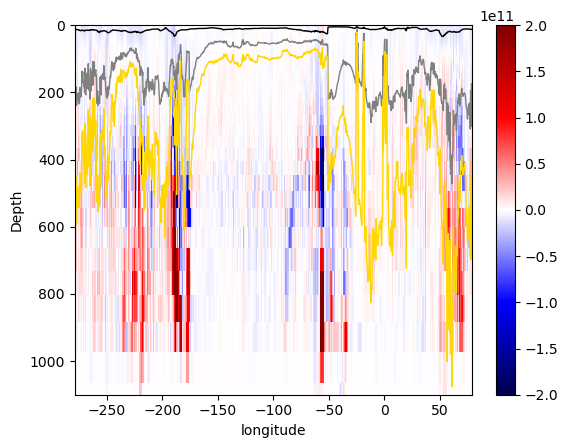

In [85]:
#plot
plt.pcolormesh(lon_bin_midpoints,IAF_HT_mean.st_ocean,
               CSHT_total_annual_mean,cmap='seismic',vmin=-2e11,vmax=2e11)
plt.colorbar(); plt.ylim(1100,0)
plt.plot(lon_bin_midpoints,mld_annualmean_contour,'grey',lw=1)
plt.plot(lon_bin_midpoints,mld_contour_min,'black',lw=1)
plt.plot(lon_bin_midpoints,mld_contour_max,'gold',lw=1)
plt.xlabel('longitude'); plt.ylabel('Depth')

In [84]:
print(' Min MLD = ' + str(int(mld_contour_min.mean())) + ' m \n Mean MLD = ' 
      + str(int(mld_annualmean_contour.mean())) + ' m \n Max MLD = ' 
      +str(int(mld_contour_max.mean())) + ' m')

 Min MLD = 13 m 
 Mean MLD = 132 m 
 Max MLD = 302 m


Previously it was suggested in the ASC meetings to use cut-off dephts ranging from 100m to 400m. Seems resonable, but as you can see the MLD changes a lot along the contour, so we should keep in mind that a fixed cutoff will be misleading in certainr regions

## 2  - CSHT below MLD

#### 2.1 Vertical slicing of CSHT and ZC

We can set the three slice choces here

In [87]:
C100=slice(100,6000) #cut above 100m
C200=slice(200,6000) #cut above 200m
C400=slice(400,6000) #cut above 400m

Cutting the heat transport to the desired depth

Lets_define the HT, and scale it already with the convergence

In [97]:
CSHT_ZC=(IAF_HT.binned_cross_slope_heat_trans + IAF_HT.zonal_convergence)*factor_t

In [99]:
C100_IAF_HT=CSHT_ZC.sel(st_ocean=C100)
C200_IAF_HT=CSHT_ZC.sel(st_ocean=C200)
C400_IAF_HT=CSHT_ZC.sel(st_ocean=C400)

Cutting the ASC speed to the desired depth

In [103]:
C100_IAF_ASC=Bin_ASC.sel(st_ocean=C100)
C200_IAF_ASC=Bin_ASC.sel(st_ocean=C200)
C400_IAF_ASC=Bin_ASC.sel(st_ocean=C400)

#### 2.2 Multi-slice comparisson

Vertical integration and along contour

In [197]:
HT_int=CSHT_ZC.sum('st_ocean').resample(time="M").mean().mean('time').load()
C100_IAF_HT_int=C100_IAF_HT.sum('st_ocean').resample(time="M").mean().mean('time').load()
C200_IAF_HT_int=C200_IAF_HT.sum('st_ocean').resample(time="M").mean().mean('time').load()
C400_IAF_HT_int=C400_IAF_HT.sum('st_ocean').resample(time="M").mean().mean('time').load()

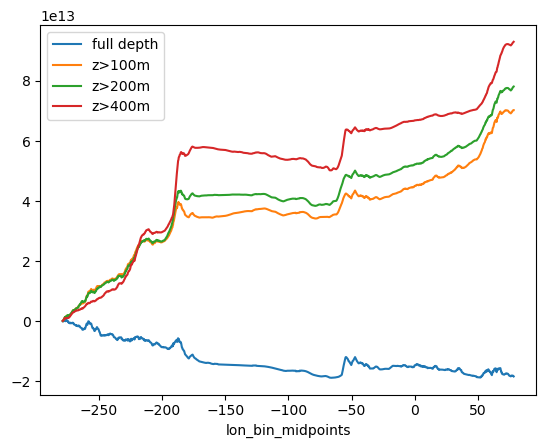

In [198]:
HT_int.cumsum().plot(label='full depth')
C100_IAF_HT_int.cumsum().plot(label='z>100m')
C200_IAF_HT_int.cumsum().plot(label='z>200m')
C400_IAF_HT_int.cumsum().plot(label='z>400m')
plt.legend()

In [187]:
unbinned_value=IAF_HT.unbinned_heat_transp_across_contour.sum('st_ocean').resample(time="M").mean().mean('time').load()


In [188]:
unbinned_value

<xarray.DataArray 'unbinned_heat_transp_across_contour' (contour_index: 6002)>
array([-1.2172763e+12, -9.4487596e+11, -8.4160499e+11, ...,
       -1.5159635e+12, -1.2344896e+12,  2.2890162e+12], dtype=float32)
Coordinates:
  * contour_index  (contour_index) int64 1 2 3 4 5 ... 5998 5999 6000 6001 6002
    TLON           (contour_index) float32 80.05 80.15 80.25 ... 79.95 79.95
    TLAT           (contour_index) float32 -66.03 -66.03 ... -66.07 -66.03
    ULON           (contour_index) float32 -279.9 -279.8 -279.7 ... 80.0 80.0
    ULAT           (contour_index) float32 -66.01 -66.01 ... -66.05 -66.01

In [173]:
test=CSHT_ZC.sum('st_ocean').sum('lon_bin_midpoints').resample(time="M").mean()


In [189]:
test

<xarray.DataArray (time: 732)>
dask.array<groupby_nanmean, shape=(732,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-12-31

In [201]:
#importing Cross 1000m isobath heat transport
iaf_HT = '/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/monthly/vertically_integrated/Ant_cross_slope_heat_terms_online_1000m_'
gl =glob.glob(iaf_HT + "*******.nc")
gl=sorted(gl)
Heat_transp_time_iaf=xr.open_mfdataset(gl, concat_dim='time', combine='nested')
IAF_THT_accross_contour = np.nansum(Heat_transp_time_iaf.heat_trans_across_contour,1)

(-140.0, 30.0)

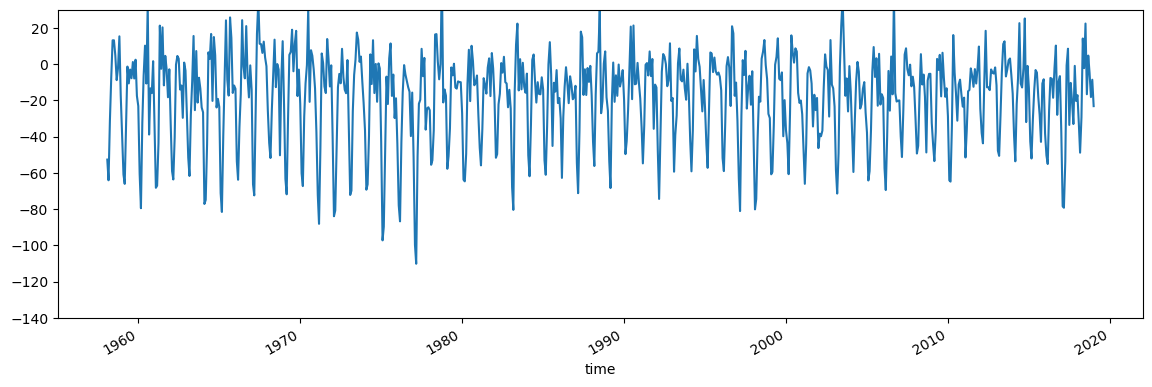

In [207]:
fig = plt.figure(figsize=(14,4))
(test/1e12).plot()
plt.ylim(-140,30)


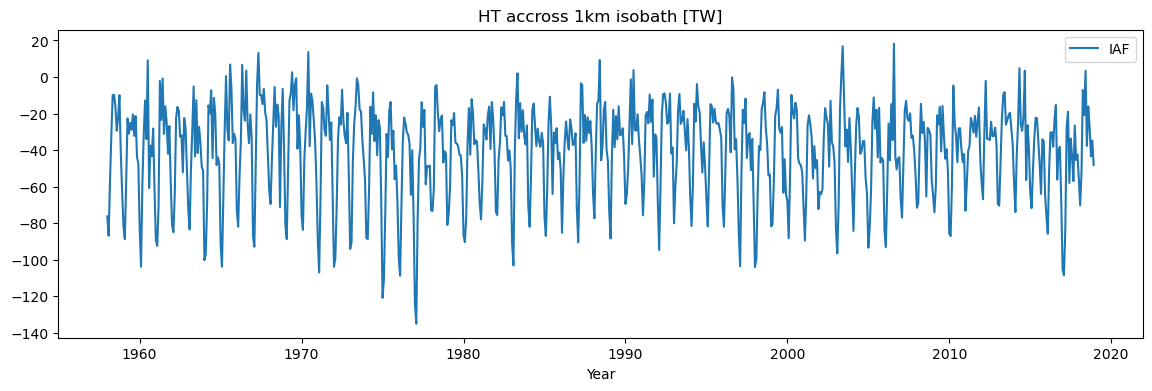

In [202]:
#total heat transport accross the 1km isobath
fig = plt.figure(figsize=(14,4))
plt.plot((np.arange(0,732)/12)+1958,IAF_THT_accross_contour/1e12,label='IAF')
plt.title('HT accross 1km isobath [TW]')
plt.xlabel('Year')
plt.legend()

difference is

In [203]:
month_to_daily_diff=(test/1e12)-IAF_THT_accross_contour/1e12

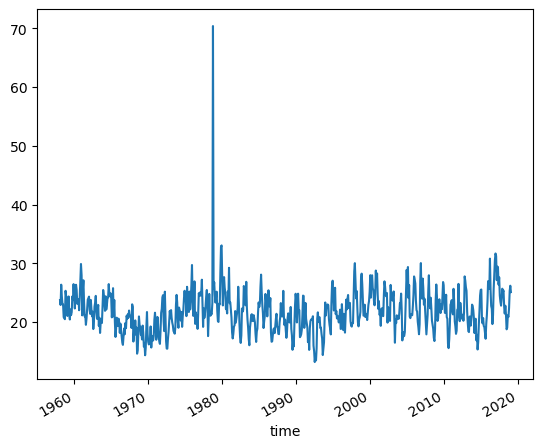

In [206]:
month_to_daily_diff.plot()

In [208]:
month_to_daily_diff.mean().values

array(21.82108418)

Difference is always positive, i.e., daily data is consistently ~25TW more positive than Monthly

In [194]:
(test.sel(time=slice('1990-01','1990-12'))/1e12).mean().values

array(-12.37530014)

Ok, notice that the timeserie slooks a lot like the one calculated with the monthly data, but it goes to more postivie values. THis makes the CSHT ing eneral be lower on the daily calculation than the monthly one.  The approach used for the monthly and daily calculationbs are different. Monthly CSHT uses tx_trans and ty_trans already calculated by the model online. OM2-IAF does not have daily tx_trans and ty_trans, so we have to calculate it offline. I remenber Adele saying there was a difference in the CSHT when calculating online and offline. So I should talk to her (maybe tomorrow)

In any case, that should explain the differences we found.